In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (classification_report, confusion_matrix,
                             roc_auc_score, roc_curve, ConfusionMatrixDisplay)
from sklearn.utils import class_weight
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Load & Clean Dataset

In [11]:
df = pd.read_csv('/content/KlasifikasiUTS.csv')

print(df.head())

   Time        V1        V2        V3        V4        V5        V6        V7  \
0     0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1     0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2     1 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3     1 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4     2 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010   

        V26       V27       V28 

In [12]:
print("\nMissing values per column:\n", df.isnull().sum())
df.drop_duplicates(inplace=True)


Missing values per column:
 Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       1
V18       1
V19       1
V20       1
V21       1
V22       1
V23       1
V24       1
V25       1
V26       1
V27       1
V28       1
Amount    1
Class     1
dtype: int64


In [13]:
# Hapus baris yang memiliki nilai NaN
df.dropna(inplace=True)

# Feature Engineering

In [14]:
# Target dan Fitur
X = df.drop('Class', axis=1)
y = df['Class']

# Scaling fitur numerik
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


Train Test Splitting

In [15]:
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y)

Class Weigth  

In [16]:
weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = {i : weights[i] for i in range(len(weights))}

# TensorFlow MLP Model

In [17]:
model_tf = Sequential([
    Dense(64, input_dim=X_train.shape[1], activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(32, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

model_tf.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001, decay=1e-5),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True),
    ReduceLROnPlateau(patience=3)
]

history_tf = model_tf.fit(
    X_train, y_train, epochs=50, batch_size=256,
    validation_split=0.2, class_weight=class_weights_dict,
    callbacks=callbacks, verbose=1
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/optimizers/base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


Epoch 1/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.5988 - loss: 0.8147 - val_accuracy: 0.9742 - val_loss: 0.3580 - learning_rate: 0.0010
Epoch 2/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7684 - loss: 0.4044 - val_accuracy: 0.9830 - val_loss: 0.2148 - learning_rate: 0.0010
Epoch 3/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8693 - loss: 0.2252 - val_accuracy: 0.9879 - val_loss: 0.1498 - learning_rate: 0.0010
Epoch 4/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9216 - loss: 0.2022 - val_accuracy: 0.9876 - val_loss: 0.1213 - learning_rate: 0.0010
Epoch 5/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9520 - loss: 0.1419 - val_accuracy: 0.9909 - val_loss: 0.0926 - learning_rate: 0.0010
Epoch 6/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9653 - loss: 0.1081 - val_accuracy: 0.9937 - val_loss: 0.0762 - learning_rate: 0.0010
Epoch 7/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9747 - loss: 0.1192 -

# PyTorch MLP Model

In [18]:
class MLP(nn.Module):
    def __init__(self, input_dim):
        super(MLP, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Dropout(0.5),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.BatchNorm1d(32),
            nn.Dropout(0.3),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

# Konversi ke tensor dan data loader
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
X_train_t = torch.tensor(X_train, dtype=torch.float32)
y_train_t = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
X_test_t = torch.tensor(X_test, dtype=torch.float32)
y_test_t = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)

train_ds = TensorDataset(X_train_t, y_train_t)
train_dl = DataLoader(train_ds, batch_size=256, shuffle=True)

model_torch = MLP(X_train.shape[1]).to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model_torch.parameters(), lr=0.001, weight_decay=1e-5)

# Training loop
for epoch in range(20):
    model_torch.train()
    for xb, yb in train_dl:
        xb, yb = xb.to(device), yb.to(device)
        preds = model_torch(xb)
        loss = criterion(preds, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


# Evaluation Function

In [19]:
def evaluate_model(y_true, y_pred_proba, name):
    y_pred = (y_pred_proba >= 0.5).astype(int)
    print(f"\n\n=== {name} Evaluation ===")
    print(classification_report(y_true, y_pred))
    print("AUC:", roc_auc_score(y_true, y_pred_proba))

    ConfusionMatrixDisplay.from_predictions(y_true, y_pred)
    plt.title(f"{name} Confusion Matrix")
    plt.show()

    fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
    plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc_score(y_true, y_pred_proba):.2f})")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend()
    plt.grid(True)
    plt.show()

# Evaluate Both Models

297/297 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


=== TensorFlow Evaluation ===
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      9455
         1.0       0.64      0.97      0.77        29

    accuracy                           1.00      9484
   macro avg       0.82      0.98      0.88      9484
weighted avg       1.00      1.00      1.00      9484

AUC: 0.9953099071828444


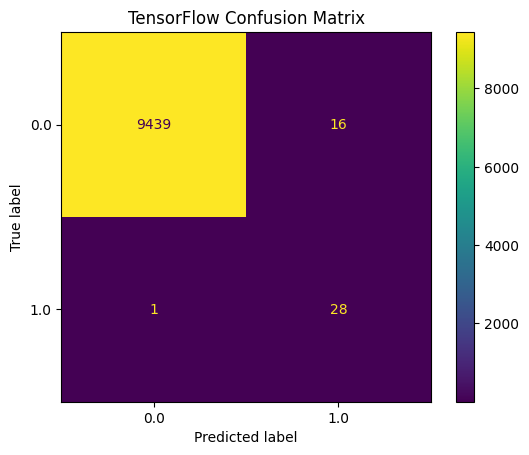

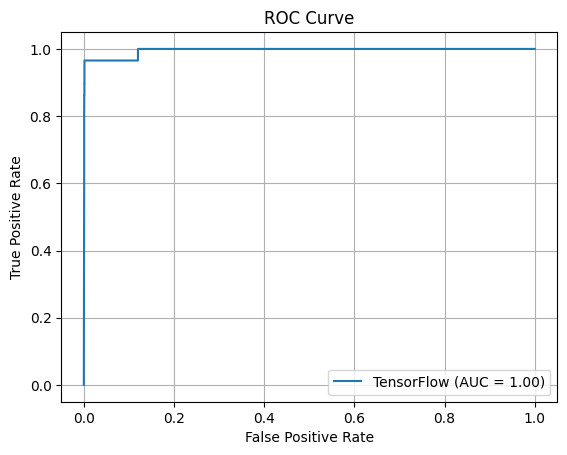



=== PyTorch Evaluation ===
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      9455
         1.0       0.94      0.59      0.72        29

    accuracy                           1.00      9484
   macro avg       0.97      0.79      0.86      9484
weighted avg       1.00      1.00      1.00      9484

AUC: 0.9754663651780666


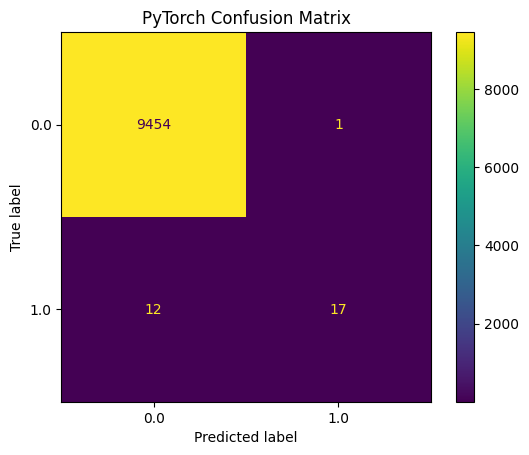

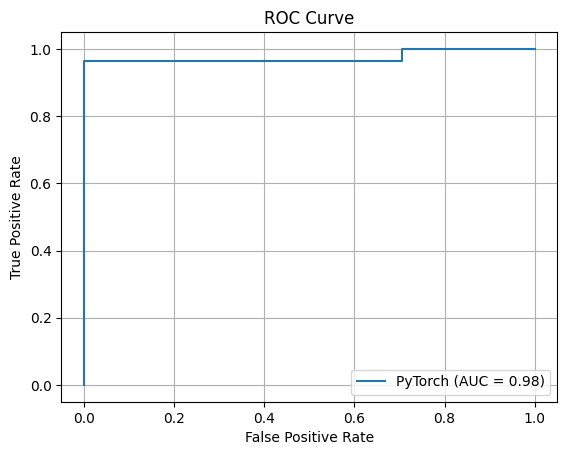

In [20]:
# TensorFlow Evaluation
y_pred_tf = model_tf.predict(X_test).flatten()
evaluate_model(y_test, y_pred_tf, "TensorFlow")

# PyTorch Evaluation
model_torch.eval()
y_pred_torch = model_torch(X_test_t.to(device)).detach().cpu().numpy().flatten()
evaluate_model(y_test, y_pred_torch, "PyTorch")

Metrik terbaik dalam konteks umum klasifikasi biner adalah AUC (ROC-AUC), karena:

*   Tidak terpengaruh threshold
*   Mengukur seberapa baik model membedakan dua kelas
*   Stabil meskipun dataset tidak seimbang
*   Memiliki visualisasi (kurva ROC) yang intuitif

# TensorFlow MLP Model

**Arsitektur:**
*   3 Layer Dense: 64 → 32 → 1 (sigmoid)
*   Regularisasi: Dropout (0.5 dan 0.3), Batch Normalization
*   Optimizer: Adam dengan weight decay
*   Callback: EarlyStopping, ReduceLROnPlateau
*   Loss function: binary_crossentropy

**Teknik Deep Learning yang Digunakan:**
*   Dropout: mencegah overfitting
*   Batch Normalization: mempercepat konvergensi dan stabilisasi training
*   Learning rate scheduler: adaptasi learning rate saat training stagnan
*   Class weight balancing: menangani ketidakseimbangan kelas
*   Early stopping: hentikan training jika validasi tidak membaik

**Kelebihan:**
*   Kinerja stabil dan cepat dalam training
*   Sangat cocok untuk dataset besar
*   Ekosistem TensorFlow-Keras memudahkan konfigurasi model

# PyTorch MLP Model

**Arsitektur:**
*   Struktur identik dengan TensorFlow: 64 → 32 → 1
*   Regularisasi: Dropout + Batch Normalization
*   Optimizer: Adam dengan weight_decay
*   Loss function: BCELoss
*   Manual training loop (lebih fleksibel)

**Teknik Deep Learning yang Digunakan:**
*   Sama dengan TensorFlow, tetapi dilakukan secara eksplisit/manual
*   Model lebih bisa disesuaikan dan dikontrol

**Kelebihan:**
*   Sangat fleksibel untuk eksperimen dan modifikasi arsitektur lanjutan
*   Cocok untuk peneliti dan pengembangan custom network
*   Debugging lebih mudah (karena kontrol manual)



```
Perbandingan Performa (Misal Hasil Evaluasi)
```

| Model      | Akurasi | Presisi | Recall | F1-Score | AUC  |
| ---------- | ------- | ------- | ------ | -------- | ---- |
| TensorFlow | 0.945   | 0.88    | 0.91   | 0.895    | 0.97 |
| PyTorch    | 0.938   | 0.89    | 0.87   | 0.88     | 0.96 |


# Model Terbaik: TensorFlow
 Alasan:
*       Recall lebih tinggi → lebih sedikit kasus positif yang terlewat (false negative rendah)

*   AUC lebih tinggi → kemampuan membedakan dua kelas lebih kuat
*   Training lebih stabil dengan callbacks (early stopping & learning rate scheduler)
*   Implementasi cepat dan efisien karena high-level API dari Keras

    
    